# SegNet Implementation

## Import

In [1]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D, BatchNormalization, Softmax, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow import device
import gc
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
gpus = list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Importing Dataset

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'C:\\DataSet\\DL Project\\Different Terrain Types Classification\\train',  
    target_size=(227, 227),      
    batch_size=16,               
    class_mode='categorical'     
)

val_generator = val_datagen.flow_from_directory(
    'C:\\DataSet\\DL Project\\Different Terrain Types Classification\\val',
    target_size=(227, 227),
    batch_size=16,
    class_mode='categorical'
)

Found 2236 images belonging to 4 classes.
Found 480 images belonging to 4 classes.


## Garbage Collection

In [4]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

## Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import ReLU, Input
import numpy as np

def segnet(input_shape=(227, 227, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),
        
        # Encoder Block 1
        Conv2D(64, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        # Encoder Block 2
        Conv2D(128, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        # Encoder Block 3
        Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        # Encoder Block 4
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        # Bridge
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        
        # Decoder Block 4
        UpSampling2D(),
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(512, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        
        # Decoder Block 3
        UpSampling2D(),
        Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        
        # Decoder Block 2
        UpSampling2D(),
        Conv2D(128, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        
        # Decoder Block 1
        UpSampling2D(),
        Conv2D(64, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, 3, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        ReLU(),
        
        # Output Layer
        GlobalAveragePooling2D(),  # This will convert (batch_size, height, width, channels) to (batch_size, channels)
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = segnet(input_shape=(227, 227, 3), num_classes=4)

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("segnet_best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
clear_memory = ClearMemory()

## Model Training

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint, clear_memory],
    verbose=1
)

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_2/batch_normalization_65/FusedBatchNormGradV3' defined at (most recent call last):
    File "C:\Users\georg\anaconda3\envs\py10\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\georg\anaconda3\envs\py10\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\georg\anaconda3\envs\py10\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\georg\anaconda3\envs\py10\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\georg\anaconda3\envs\py10\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\georg\AppData\Local\Temp\ipykernel_472\4117565292.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\georg\anaconda3\envs\py10\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_2/batch_normalization_65/FusedBatchNormGradV3'
OOM when allocating tensor with shape[16,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_2/batch_normalization_65/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_9724]

## Accuracy Dataset

In [18]:
test_data_dir = 'C:\\DataSet\\DL Project\\Different Terrain Types Classification\\test'
target_size = (227, 227) 
num_classes = 4           

def load_images_and_labels(data_dir, target_size, num_classes):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  
            images.append(img_array)
            labels.append(class_index)  

    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    return images, labels

## Importing saved weights

In [19]:
model.load_weights('segnet_best_model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'segnet_best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Calculaing Accuracy?

In [20]:
X_test, y_test = load_images_and_labels(test_data_dir, target_size, num_classes)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 12s 584ms/step - loss: 1.3656 - accuracy: 0.2500
Test Loss: 1.365621566772461
Test Accuracy: 0.25


In [21]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test,y_pred))

15/15 [==============================] - 9s 596ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.00      0.00      0.00       120
           2       0.25      1.00      0.40       120
           3       0.00      0.00      0.00       120

    accuracy                           0.25       480
   macro avg       0.06      0.25      0.10       480
weighted avg       0.06      0.25      0.10       480



C:\Users\georg\anaconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\georg\anaconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\georg\anaconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


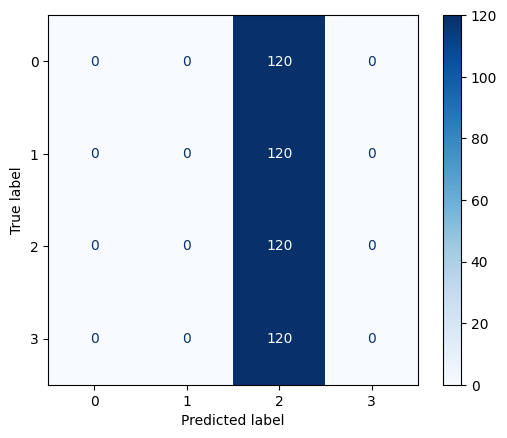

In [22]:
cm = confusion_matrix(y_test, y_pred)

display_labels = [0, 1, 2, 3]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

cm_display.plot(cmap='Blues')
plt.show()